# Unsupervised Learning Techniques for weather data

## K-Means

In [51]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp


In [52]:
from sklearn.cluster import KMeans

In [53]:
dfXy = pd.read_csv('weather_data.csv', usecols=range(8)).copy()
dfX = pd.read_csv('weather_data.csv', usecols=range(7)).copy()
df_dummies = pd.get_dummies(dfXy['Condition'])
df_with_dummies = pd.concat([dfX, df_dummies], axis=1)
df_with_dummies.tail()

,Temperature(°C),Dew Point(°F),Humidity(°%),Wind Speed(°mph),Wind Gust(°mph),Pressure(°in),Precip.,Cloudy,Cloudy / Windy,Drizzle,...,Snow Shower,Snow Shower / Windy,Snow and Thunder,T-Storm,T-Storm / Windy,Thunder,Thunder / Wintry Mix,Thunder in the Vicinity,Wintry Mix,Wintry Mix / Windy
48166,9,4,71,13,0,31,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48167,9,4,71,12,0,31,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48168,9,4,71,10,0,31,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48169,9,4,71,12,0,31,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48170,9,4,71,13,0,31,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
dfX_sc = scaler.fit_transform(dfX)

### Determination of optimum number of clusters

In [55]:
from yellowbrick.cluster import KElbowVisualizer
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(1,10))

Avoid warnings:

In [56]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

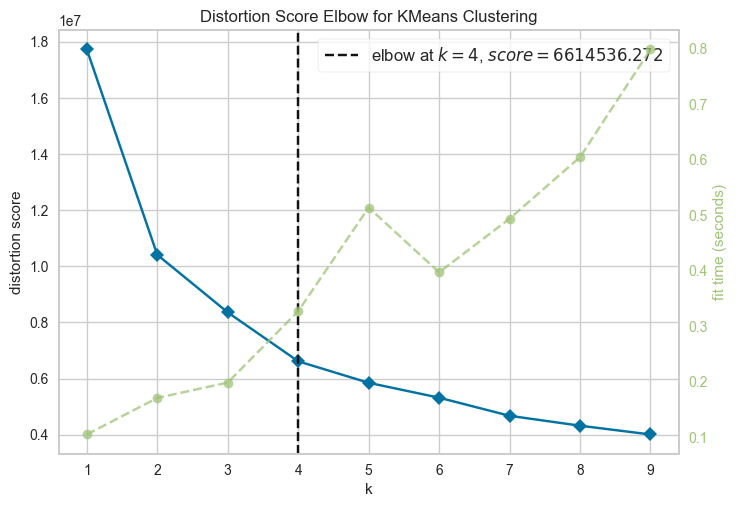

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [57]:
visualizer.fit(dfX)
visualizer.poof()

Let's assume that best k = 4

Another way to figure out the best k

In [ ]:
for i in range(1,10):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=23)
    kmeans.fit()


ChatGBT does make that:

In [20]:
k = 4
kmeans = KMeans(n_clusters=k, init = 'k-means++',random_state=23) #best n_clusters evaluated as 4
k_fit = kmeans.fit(df_dummies_scalled)
dfXy['Cluster'] = kmeans.predict(df_dummies_scalled)
cluster_mapping = {i: dfXy.loc[dfXy['Cluster'] == i, 'Condition'].unique() for i in range(k)}
print(cluster_mapping)


{0: array(['Mostly Cloudy'], dtype=object), 1: array(['Fair', 'Light Rain Shower', 'Mostly Cloudy / Windy',
       'Light Rain Shower / Windy', 'Fair / Windy', 'Rain Shower',
       'Rain Shower / Windy', 'Light Rain', 'Cloudy', 'Rain',
       'Partly Cloudy / Windy', 'Light Drizzle',
       'Light Rain with Thunder', 'Wintry Mix / Windy',
       'Light Snow Shower / Windy', 'Light Snow Shower', 'Wintry Mix',
       'Snow Shower', 'Heavy Snow Shower / Windy', 'Heavy Snow Shower',
       'Snow Shower / Windy', 'Fog', 'Drizzle', 'Thunder',
       'T-Storm / Windy', 'T-Storm', 'Light Rain / Windy',
       'Cloudy / Windy', 'Thunder in the Vicinity', 'Patches of Fog',
       'Light Drizzle / Windy', 'Light Snow', 'Light Snow / Windy',
       'Heavy Snow', 'Mist / Windy', 'Thunder / Wintry Mix',
       'Rain / Windy', 'Snow and Thunder', 'Light Snow with Thunder',
       'Heavy Snow with Thunder', 'Heavy Rain Shower', 'Heavy T-Storm'],
      dtype=object), 2: array(['Mist'], dtype=object), 

In [109]:
kmeans = KMeans(n_clusters=4, random_state=23) #best n_clusters evaluated as 4
k_fit = kmeans.fit(df_with_dummies)
clusters = k_fit.labels_
clusters

array([3, 0, 3, ..., 0, 0, 0])

In [110]:
df_clusters = pd.DataFrame({'Clusters': clusters})
df_unsupervised = pd.concat([dfXy, df_clusters], axis=1)
df_unsupervised.iloc[:,-1].value_counts()

2    13149
3    12611
0    12486
1     9925
Name: Clusters, dtype: int64

### K-Means Model&Visualization

In [55]:
kmeans = KMeans(n_clusters=2)
k_fit = kmeans.fit(df_X)

In [56]:
k_fit.cluster_centers_

array([[19.6962762 , 10.92483354, 57.45020962, 11.18377312,  0.3988656 ,
        30.08177559,  0.        ],
       [13.50845999, 10.32692859, 81.53595498,  9.1222756 ,  0.51831804,
        30.20977918,  0.        ]])

In [57]:
k_fit.labels_

array([1, 1, 1, ..., 1, 1, 1])

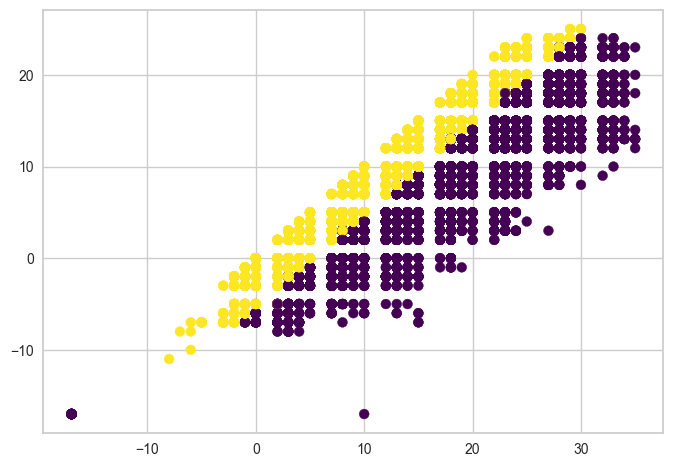

In [58]:
labels = k_fit.labels_
plt.scatter(df.iloc[:,0], df.iloc[:,1],c = labels, s = 50, cmap = 'viridis')

### Clustering Weather due to K-Means (k=4) 

In [102]:
df_org = pd.read_csv('weather_data.csv')
df_org

df_with_clusters = pd.concat([df_org, df_unsupervised.loc[:,'Clusters']], axis=1)
df_with_clusters.tail(3)

,Temperature(°C),Dew Point(°F),Humidity(°%),Wind Speed(°mph),Wind Gust(°mph),Pressure(°in),Precip.,Condition,Clusters
48168,9,4,71,10,0,31,0.0,Fair,3
48169,9,4,71,12,0,31,0.0,Fair,3
48170,9,4,71,13,0,31,0.0,Fair,3


In [103]:
df_with_clusters.to_csv('weather_data_unsupervise.csv', index= False)

In [104]:
for cluster in range(4):
    df_cluster_group = df_with_clusters.groupby('Clusters').get_group(cluster)
    print(f'\nCluster: {cluster} value counts:\n','-'*30,'\n', df_cluster_group['Condition'].value_counts())


Cluster: 0 value counts:
 ------------------------------ 
 Fair                         4091
Mostly Cloudy                3601
Light Rain Shower            1803
Partly Cloudy                 597
Light Rain                    508
Mist                          391
Light Snow Shower             297
Light Rain Shower / Windy     237
Mostly Cloudy / Windy         205
Rain Shower                   105
Cloudy                        100
Light Rain / Windy             95
Fog                            82
Wintry Mix                     81
Rain Shower / Windy            60
Snow Shower                    52
Light Rain with Thunder        47
Light Snow Shower / Windy      39
T-Storm                        32
Light Drizzle                  29
Rain                           28
Patches of Fog                 25
Heavy Snow Shower              18
T-Storm / Windy                12
Snow Shower / Windy            11
Wintry Mix / Windy             11
Drizzle                         7
Heavy Snow with Thunde

As it's observed, K-Means does not work well on this dataset. Or there could be another reason. But in my opinion, we should try hierarchical clustering which different algorithm for clustering.

## Hierarchical Clustering